In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pydot
from tensorflow.keras.utils import plot_model
import pc  # custom module

# Check CUDA support
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("CUDA enabled.")
else:
    print("CUDA not enabled.")

# Path to dataset
data_folder = "/app/data"
# Training parameters
EP = 100
BS = 64
# Image resolution
RES = (224, 224)
# Random seed
SEED = 42

# Enable automatic mixed precision (not compatible with my GPU GeForce GTX 1060 6GB)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

CUDA enabled.


In [2]:
!ls /app/data

PokemonData


In [3]:
data_dict = pc.create_dataset(
    data_folder,
    epochs=EP,
    batch_size=BS,
    res=RES,
    seed=SEED,
)

ValueError: not enough values to unpack (expected 2, got 0)

In [4]:
train_dataset = data_dict["train_dataset"]
val_dataset = data_dict["val_dataset"]
test_dataset = data_dict["test_dataset"]
train_len = data_dict["train_len"]
val_len = data_dict["val_len"]
test_len = data_dict["test_len"]
label_encoder = data_dict["label_encoder"]

print(f"Number of training samples: {train_len}")
print(f"Number of validation samples: {val_len}")
print(f"Number of test samples: {test_len}")

Number of training samples: 5471
Number of validation samples: 594
Number of test samples: 594


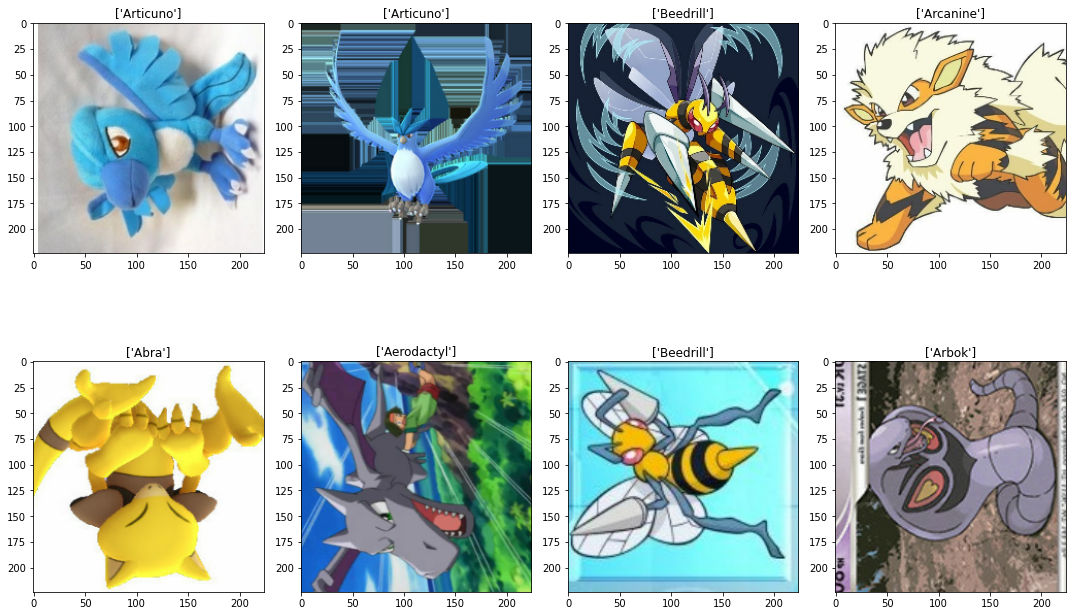

In [5]:
plt.figure(figsize=(15, 10))

# Iterate over batches
for (image_batch, label_batch) in train_dataset:
    # Iterate over elements in batch
    for i, (image, label) in enumerate(zip(image_batch[:8], label_batch[:8])):
        plt.subplot(2, 4, i + 1)
        plt.title(label_encoder.inverse_transform([label]))
        plt.imshow((255 * image.numpy()).astype(np.uint8))
    break

plt.tight_layout()
plt.show()

In [ ]:
train_labels = []
train_it = iter(train_dataset)
for i in range(train_len // BS):
    (_, label_batch) = next(train_it)
    for label in label_batch:
        train_labels.append(label.numpy())
print("Training: done")
        
val_labels = []
val_it = iter(val_dataset)
for i in range(val_len // BS):
    (_, label_batch) = next(val_it)
    for label in label_batch:
        val_labels.append(label.numpy())
print("Validation: done")

test_labels = []
test_it = iter(test_dataset)
for i, (_, label) in enumerate(test_it):
    test_labels.append(label.numpy())
print("Test: done")

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.hist(train_labels, bins=150)
plt.title("Training classes")
plt.subplot(3, 1, 2)
plt.hist(val_labels, bins=150)
plt.title("Validation classes")
plt.subplot(3, 1, 3)
plt.hist(test_labels, bins=150)
plt.title("Test classes")
plt.tight_layout()
plt.show()

Training: done
Validation: done
Test: done


In [ ]:
model = pc.create_model(n_conv=5, use_bn=True, res=RES)
model.summary()
plot_model(model, show_shapes=True)

In [7]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=EP,
    callbacks=[callback],
    steps_per_epoch=train_len // BS,
    validation_data=val_dataset,
    validation_steps=val_len // BS
)

Epoch 1/100
85/85 [==============================] - 13s 130ms/step - loss: 8.8216 - accuracy: 0.0272 - val_loss: 6.1901 - val_accuracy: 0.0122
Epoch 2/100
85/85 [==============================] - 11s 129ms/step - loss: 6.9257 - accuracy: 0.0218 - val_loss: 6.4499 - val_accuracy: 0.0191
Epoch 3/100
85/85 [==============================] - 11s 128ms/step - loss: 6.2104 - accuracy: 0.0296 - val_loss: 5.4099 - val_accuracy: 0.0469
Epoch 4/100
85/85 [==============================] - 11s 129ms/step - loss: 5.5035 - accuracy: 0.0390 - val_loss: 5.6962 - val_accuracy: 0.0451
Epoch 5/100
85/85 [==============================] - 11s 129ms/step - loss: 4.9091 - accuracy: 0.0634 - val_loss: 6.4874 - val_accuracy: 0.0451
Epoch 6/100
85/85 [==============================] - 11s 129ms/step - loss: 4.7287 - accuracy: 0.0716 - val_loss: 5.4719 - val_accuracy: 0.0399
Epoch 7/100
85/85 [==============================] - 11s 129ms/step - loss: 4.4726 - accuracy: 0.0755 - val_loss: 7.1475 - val_accuracy:

In [9]:
# Save model (tensorflow standard format)
model.save("model2")

INFO:tensorflow:Assets written to: model1/assets


In [8]:
model = tf.keras.models.load_model('./model1')

In [9]:
test_dict = model.evaluate(
    test_dataset,
    steps=test_len,
    return_dict=True
)

594/594 [==============================] - 4s 5ms/step - loss: 0.0171 - accuracy: 0.9966


In [ ]:
plt.figure(figsize=(10, 15))  # set graph dimension

# 1. First graph

plt.subplot(1, 2, 1)  # creates 1 subplot out of 2

plt.title("Training and validation loss")
plt.plot(history.hist["loss"], label="Training loss")
plt.plot(history.hist["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Loss")
plt.grid()

# 2. Second Graph

plt.subplot(1, 2, 2)  # creates 1 subplot out of 2

plt.title("Training and validation accuracy")
plt.plot(history.hist["accuracy"], label="Training accuracy")
plt.plot(history.hist["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()